In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath("Tutorial_Rocks_Inversion.ipynb"))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

In [2]:
# MODULES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules import sequences, minerals, fluids
from modules.sequences import SedimentaryBasin
from modules import geophysics
from pandas.plotting import scatter_matrix
import seaborn as sn
from scipy.optimize import nnls, minimize
import scipy.optimize as opt
import time

In [11]:
# Test feldspathic sandstone generation within SedimentaryBasin class
data = SedimentaryBasin()
data_sandstone = data.create_sandstone(thickness=10, keyword="feldspathic")
print(data_sandstone[0])

data = sequences.DataProcessing(dataset=data_sandstone)
density_bulk = data.extract_densities(type="rock", keyword="bulk")
vP = data.extract_seismic_velocities(type="rock", keyword="vP")
vS = data.extract_seismic_velocities(type="rock", keyword="vS")
gr = data.extract_gamma_ray(type="rock")
pe = data.extract_photoelectricity(type="rock")

d = []
for i in range(len(data_sandstone)):
    d.append([density_bulk[i]*1000, vP[i], vS[i], gr[i], pe[i]])
    print("Sample", i+1, ":", d[i])
d = np.array(d)

['sandstone', 1.0, 0, 1.0, [[['O', 'Na', 'Al', 'Si', 'K', 'Ca'], ['Qz', 'Kfs', 'Pl']], [2.166, 2.641, 1.0], [10.06, 5.57, 14.11, 0.101], [2841.48, 1603.55, 3408.17, 1449.1], [0.289, 0.289, 0.289], ['water', 0.1541], [3.386, 1.691], [0.511, 0.0323, 0.0505, 0.3959, 0.0021, 0.0082], [0.5592, 0.2036, 0.2372]]]
Sample 1 : [2166.0, 2841.48, 1603.55, 3.386, 1.691]
Sample 2 : [2073.0, 2676.98, 1454.71, 0.453, 1.669]
Sample 3 : [2221.0, 2854.97, 1656.22, 26.936, 1.835]
Sample 4 : [2154.0, 2757.61, 1558.79, 24.23, 1.797]
Sample 5 : [2101.0, 2667.98, 1477.91, 17.056, 1.712]
Sample 6 : [2168.0, 2697.12, 1537.8, 23.764, 1.925]
Sample 7 : [2231.0, 2742.11, 1612.44, 16.488, 1.867]
Sample 8 : [2092.0, 2619.01, 1440.84, 7.454, 1.816]
Sample 9 : [2119.0, 2697.92, 1500.69, 5.284, 1.742]
Sample 10 : [2144.0, 2736.92, 1543.14, 14.375, 1.73]


In [12]:
data_qz = minerals.oxides.quartz("")
data_kfs = minerals.feldspars().alkalifeldspar(keyword="Kfs")
data_pl = minerals.feldspars().plagioclase(keyword="Pl")
water = fluids.Water.water("")

print("Quartz:\n", data_qz)
print("Alkalifeldspar:\n", data_kfs)
print("Plagioclase:\n", data_pl)
print("Water:\n", water)

properties_rho = [data_qz[2], data_kfs[2], data_pl[2], water[2]]
properties_vP = [data_qz[4][0], data_kfs[4][0], data_pl[4][0], water[4][0]]
properties_vS = [data_qz[4][1], data_kfs[4][1], data_pl[4][1], water[4][1]]
properties_GR = [data_qz[5][0], data_kfs[5][0], data_pl[5][0], water[5][0]]
properties_PE = [data_qz[5][1], data_kfs[5][1], data_pl[5][1], water[5][1]]

properties_rho_s = [data_qz[2], data_kfs[2], data_pl[2]]
properties_vP_s = [data_qz[4][0], data_kfs[4][0], data_pl[4][0]]
properties_vS_s = [data_qz[4][1], data_kfs[4][1], data_pl[4][1]]
properties_GR_s = [data_qz[5][0], data_kfs[5][0], data_pl[5][0]]
properties_PE_s = [data_qz[5][1], data_kfs[5][1], data_pl[5][1]]

G = np.array([properties_rho, properties_vP, properties_vS, properties_GR, properties_PE])
G_s = np.array([properties_rho_s, properties_vP_s, properties_vS_s, properties_GR_s, properties_PE_s])
#print(G)

G_T = np.transpose(G)
G_TG = G_T@G
GTG_inv = np.linalg.inv(G_TG)
m = GTG_inv@G_T@d[0]
#print(m)

G_T_s = np.transpose(G_s)
G_TG_s = G_T_s@G_s
GTG_inv_s = np.linalg.inv(G_TG_s)
m_s = GTG_inv_s@G_T_s@d[0]
#print(m_s)

Quartz:
 ['Qz', 60.08, 2648.6, [29.0, 44.0, 87.66, -0.0, 1.41], [5753.2, 4075.9], [0, 1.65, 4.37, 200000000000000], [0.5326, 0.4674]]
Alkalifeldspar:
 ['Kfs', [275.75, 0.16], 2580.3, [91.97, 62.72, 153.3, 0.22, 1.67], [8249.3, 4930.1], [190.56, 2.47, 6.36, 550000000000.0], [0.4642, 0.0133, 0.0978, 0.3055, 0.1191]]
Plagioclase:
 ['Pl', [275.65, 0.16], 2731.6, [112.92, 72.96, 180.1, 0.23, 1.7], [8772.2, 5168.3], [0, 2.65, 7.24, 550000000000.0], [0.4643, 0.0133, 0.1801, 0.2201, 0.1221]]
Water:
 ['H2O', 18.02, 1000.0, [2.1, 0.0, 0.0, 0.5, inf], [1449.1, 0.0], [0, 0.36, 0.36]]


In [13]:
m = np.linalg.lstsq(a=G, b=d[0], rcond=None)[0]
print("Model estimation:", m, m.sum())
print("Check:")
print("Density:", round(np.dot(m,properties_rho), 2))
print("vP:", round(np.dot(m,properties_vP), 2))
print("vS:", round(np.dot(m,properties_vS), 2))
print("GR:", round(np.dot(m,properties_GR), 2))
print("PE:", round(np.dot(m,properties_PE), 2))
print("Reality:")
print(d[0])

Model estimation: [ 0.95117265  0.01776809 -0.45681038  0.84870021] 1.360830582931086
Check:
Density: 2166.0
vP: 2841.48
vS: 1603.55
GR: 3.39
PE: 0.71
Reality:
[2.16600e+03 2.84148e+03 1.60355e+03 3.38600e+00 1.69100e+00]


In [14]:
m_s = np.linalg.lstsq(a=G_s, b=d[0], rcond=None)[0]
print("Model estimation:", m_s, m_s.sum())
print("Check:")
print("Density:", round(np.dot(m_s, properties_rho_s), 2))
print("vP:", round(np.dot(m_s, properties_vP_s), 2))
print("vS:", round(np.dot(m_s, properties_vS_s), 2))
print("GR:", round(np.dot(m_s, properties_GR_s), 2))
print("PE:", round(np.dot(m_s, properties_PE_s), 2))
print("Reality:")
print(d[0])

Model estimation: [ 1.02888986 -0.96877957  0.53727477] 0.5973850624818782
Check:
Density: 1693.0
vP: 2640.74
vS: 2194.27
GR: -184.61
PE: 0.73
Reality:
[2.16600e+03 2.84148e+03 1.60355e+03 3.38600e+00 1.69100e+00]


In [15]:
A = G
b = d[0]

m0, rnorm = nnls(A, b)
print("Model estimation:", m0, m0.sum())
print("Check:")
print("Density:", round(np.dot(m0,properties_rho), 2))
print("vP:", round(np.dot(m0,properties_vP), 2))
print("vS:", round(np.dot(m0,properties_vS), 2))
print("GR:", round(np.dot(m0,properties_GR), 2))
print("PE:", round(np.dot(m0,properties_PE), 2))
print("Reality:")
print(d[0])

Model estimation: [0.35694614 0.         0.         0.76207039] 1.1190165292877317
Check:
Density: 1707.48
vP: 3157.9
vS: 1454.88
GR: 0.0
PE: 0.86
Reality:
[2.16600e+03 2.84148e+03 1.60355e+03 3.38600e+00 1.69100e+00]


In [16]:
A = G_s
b = d[0]

m0, rnorm = nnls(A, b)
print("Model estimation:", m0, m0.sum())
print("Check:")
print("Density:", round(np.dot(m0, properties_rho_s), 2))
print("vP:", round(np.dot(m0, properties_vP_s), 2))
print("vS:", round(np.dot(m0, properties_vS_s), 2))
print("GR:", round(np.dot(m0, properties_GR_s), 2))
print("PE:", round(np.dot(m0, properties_PE_s), 2))
print("Reality:")
print(d[0])

Model estimation: [0.50452524 0.         0.        ] 0.5045252365738765
Check:
Density: 1336.29
vP: 2902.63
vS: 2056.39
GR: 0.0
PE: 0.83
Reality:
[2.16600e+03 2.84148e+03 1.60355e+03 3.38600e+00 1.69100e+00]


In [17]:
import numpy as np
from scipy.optimize import minimize 
from scipy.optimize import nnls 

#Define problem
A = np.array([[60, 90, 120], 
              [30, 120, 90]])
A = G

b = np.array([67.5, 60])
b = d[0]

#Use nnls to get initial guess
x0, rnorm = nnls(A, b)

#Define minimisation function
def fn(x, A, b):
    return np.linalg.norm(A.dot(x) - b)

#Define constraints and bounds
cons = {'type': 'eq', 'fun': lambda x:  np.sum(x)-1}
bounds = [[0.5, 1.0], [0., 0.5], [0., 0.5], [0., 0.2]]

#Call minimisation subject to these values
minout = minimize(fn, x0, args=(A, b), method="SLSQP", bounds=bounds, constraints=cons)
x = minout.x

print(x, x.sum(), fn(x,A,b))
m0 = x

print("")
print("Model estimation:", m0, m0.sum())
print("Check:")
print("Density:", round(np.dot(m0,properties_rho), 2), "-->", round((np.dot(m0,properties_rho)/d[0][0]-1)*100, 2), "% difference")
print("vP:", round(np.dot(m0,properties_vP), 2), "-->", round((np.dot(m0,properties_vP)/d[0][1]-1)*100, 2), "% difference")
print("vS:", round(np.dot(m0,properties_vS), 2), "-->", round((np.dot(m0,properties_vS)/d[0][2]-1)*100, 2), "% difference")
print("GR:", round(np.dot(m0,properties_GR), 2), "-->", round((np.dot(m0,properties_GR)/d[0][3]-1)*100, 2), "% difference")
print("PE:", round(np.dot(m0,properties_PE), 2), "-->", round((np.dot(m0,properties_PE)/d[0][4]-1)*100, 2), "% difference")
print("Reality:")
print(d[0])

[7.99999901e-01 4.13922389e-08 3.57262115e-08 2.00000000e-01] 0.9999999782351681 2641.171587603426

Model estimation: [7.99999901e-01 4.13922389e-08 3.57262115e-08 2.00000000e-01] 0.9999999782351681
Check:
Density: 2318.88 --> 7.06 % difference
vP: 4892.38 --> 72.18 % difference
vS: 3260.72 --> 103.34 % difference
GR: 0.0 --> -100.0 % difference
PE: 1.39 --> -17.68 % difference
Reality:
[2.16600e+03 2.84148e+03 1.60355e+03 3.38600e+00 1.69100e+00]


In [18]:
import numpy as np
from scipy.optimize import minimize 
from scipy.optimize import nnls 

#Define problem
A = G_s
b = d[0]

#Use nnls to get initial guess
x0, rnorm = nnls(A, b)

#Define minimisation function
def fn(x, A, b):
    return np.linalg.norm(A.dot(x) - b)

#Define constraints and bounds
cons = {'type': 'eq', 'fun': lambda x:  np.sum(x)-1}
bounds = [[0.5, 1.0], [0., 0.5], [0., 0.5]]

#Call minimisation subject to these values
minout = minimize(fn, x0, args=(A, b), method="SLSQP", bounds=bounds, constraints=cons)
x = minout.x

print(x, x.sum(), fn(x, A, b))
m0 = x

print("")
print("Model estimation:", m0, m0.sum())
print("Check:")
print("Density:", round(np.dot(m0, properties_rho_s), 2), "-->", round((np.dot(m0, properties_rho_s)/d[0][0]-1)*100, 2), "% difference")
print("vP:", round(np.dot(m0, properties_vP_s), 2), "-->", round((np.dot(m0, properties_vP_s)/d[0][1]-1)*100, 2), "% difference")
print("vS:", round(np.dot(m0, properties_vS_s), 2), "-->", round((np.dot(m0, properties_vS_s)/d[0][2]-1)*100, 2), "% difference")
print("GR:", round(np.dot(m0, properties_GR_s), 2), "-->", round((np.dot(m0, properties_GR_s)/d[0][3]-1)*100, 2), "% difference")
print("PE:", round(np.dot(m0, properties_PE_s), 2), "-->", round((np.dot(m0, properties_PE_s)/d[0][4]-1)*100, 2), "% difference")
print("Reality:")
print(d[0])

[1.00000000e+00 1.22792747e-10 0.00000000e+00] 1.000000000090709 3850.135337227954

Model estimation: [1.00000000e+00 1.22792747e-10 0.00000000e+00] 1.000000000090709
Check:
Density: 2648.6 --> 22.28 % difference
vP: 5753.2 --> 102.47 % difference
vS: 4075.9 --> 154.18 % difference
GR: 0.0 --> -100.0 % difference
PE: 1.65 --> -2.42 % difference
Reality:
[2.16600e+03 2.84148e+03 1.60355e+03 3.38600e+00 1.69100e+00]


In [19]:
w_Qz = np.linspace(0.5, 1.0, 201)
w_Kfs = np.linspace(0, 0.5, 201)
w_Pl = np.linspace(0, 0.5, 201)
w_H2O = np.linspace(0, 0.2, 41)

print("Qz:", w_Qz, len(w_Qz))
print("Kfs:", w_Kfs, len(w_Kfs))
print("Pl:", w_Pl, len(w_Pl))
print("H2O:", w_H2O, len(w_H2O))

Qz: [0.5    0.5025 0.505  0.5075 0.51   0.5125 0.515  0.5175 0.52   0.5225
 0.525  0.5275 0.53   0.5325 0.535  0.5375 0.54   0.5425 0.545  0.5475
 0.55   0.5525 0.555  0.5575 0.56   0.5625 0.565  0.5675 0.57   0.5725
 0.575  0.5775 0.58   0.5825 0.585  0.5875 0.59   0.5925 0.595  0.5975
 0.6    0.6025 0.605  0.6075 0.61   0.6125 0.615  0.6175 0.62   0.6225
 0.625  0.6275 0.63   0.6325 0.635  0.6375 0.64   0.6425 0.645  0.6475
 0.65   0.6525 0.655  0.6575 0.66   0.6625 0.665  0.6675 0.67   0.6725
 0.675  0.6775 0.68   0.6825 0.685  0.6875 0.69   0.6925 0.695  0.6975
 0.7    0.7025 0.705  0.7075 0.71   0.7125 0.715  0.7175 0.72   0.7225
 0.725  0.7275 0.73   0.7325 0.735  0.7375 0.74   0.7425 0.745  0.7475
 0.75   0.7525 0.755  0.7575 0.76   0.7625 0.765  0.7675 0.77   0.7725
 0.775  0.7775 0.78   0.7825 0.785  0.7875 0.79   0.7925 0.795  0.7975
 0.8    0.8025 0.805  0.8075 0.81   0.8125 0.815  0.8175 0.82   0.8225
 0.825  0.8275 0.83   0.8325 0.835  0.8375 0.84   0.8425 0.845  0.8475
 0

In [115]:
rho_calc = []
indices_rho = []

rho_sample = d[0][0]
rho_Qz = properties_rho[0]
rho_Kfs = properties_rho[1]
rho_Pl = properties_rho[2]
rho_H2O = properties_rho[3]

limit_lower_rho = 0.9975
limit_upper_rho = 1.0025

print("Density rho:")
print("Sample rho:", rho_sample)
print("Allowed range:", round(limit_lower_rho*rho_sample, 1), round(limit_upper_rho*rho_sample, 1))
print("")

start = time.process_time()
for j in w_Kfs:
    for k in w_Pl:
        w_fsp = j+k
        if w_fsp <= 0.5:
            for i in w_Qz:
                if i+j+k == 1.0:
                    for l in w_H2O:
                        phi = round((l/rho_H2O)/(i/rho_Qz + j/rho_Kfs + k/rho_Pl + l/rho_H2O), 4)
                        value_rho = (1-phi)*(i*rho_Qz + j*rho_Kfs + k*rho_Pl) + phi*rho_H2O
                        if limit_lower_rho*rho_sample < value_rho < limit_upper_rho*rho_sample:
                            rho_calc.append(value_rho)
                            indices_rho.append([i, j, k, l])
                                
print("Needed time:", round(time.process_time() - start, 3), "s")
print("Datapoints:", len(rho_calc))

Density rho:
Sample rho: 2166.0
Allowed range: 2160.6 2171.4

Needed time: 5.054 s
Datapoints: 18649


Text(0, 0.5, 'wFsP')

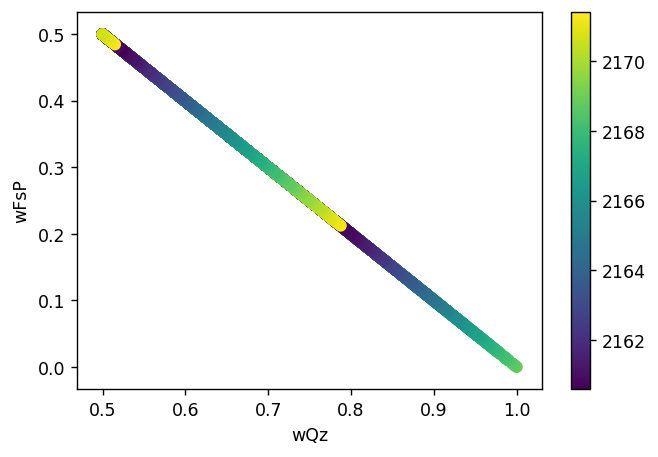

In [78]:
indices_rho = np.array(indices_rho)
x_rho = indices_rho[:, 0]
y_rho = indices_rho[:, 1]+indices_rho[:, 2]
z_rho = np.array(rho_calc)

plt.subplots(dpi=125)
plt.scatter(x=x_rho, y=y_rho, c=z_rho)
plt.colorbar()
plt.xlabel("wQz")
plt.ylabel("wFsP")

In [73]:
vP_calc = []
indices_vP = []
limit_lower_vP = 0.9975
limit_upper_vP = 1.0025

vP_sample = d[0][1]
vP_Qz = properties_vP[0]
vP_Kfs = properties_vP[1]
vP_Pl = properties_vP[2]
vP_H2O = properties_vP[3]

print("Velocity vP:")
print("Sample vP:", vP_sample)
print("Allowed range:", round(limit_lower_vP*vP_sample, 2), round(limit_upper_vP*vP_sample, 2))
print("")

start = time.process_time()
for j in w_Kfs:
    for k in w_Pl:
        w_fsp = j+k
        if w_fsp <= 0.5:
            for i in w_Qz:
                if i+j+k == 1.0:
                    for l in w_H2O:
                        phi = round((l/rho_H2O)/(i/rho_Qz + j/rho_Kfs + k/rho_Pl + l/rho_H2O), 4)
                        value_vP = 0.5282*((1-phi)*(i*vP_Qz + j*vP_Kfs + k*vP_Pl) + phi*vP_H2O)
                        if limit_lower_vP*vP_sample < value_vP < limit_upper_vP*vP_sample:
                            vP_calc.append(value_vP)
                            indices_vP.append([i, j, k, l])
                                
print("Needed time:", round(time.process_time() - start, 3), "s")
print("Datapoints:", len(vP_calc))

Velocity vP:
Sample vP: 2841.48
Allowed range: 2834.38 2848.58

Needed time: 5.121 s
Datapoints: 12911


Text(0, 0.5, 'wFsP')

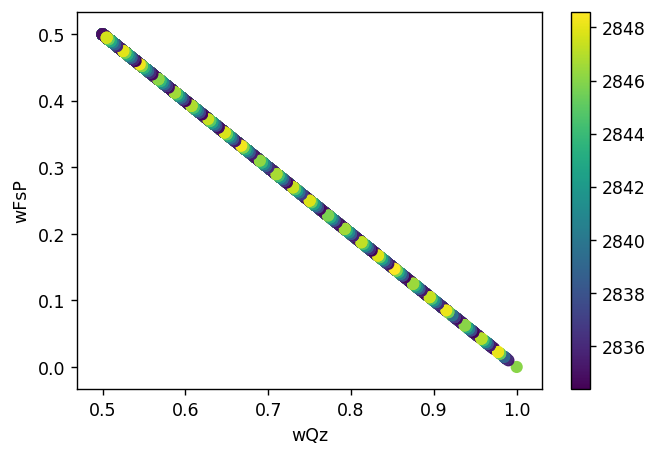

In [77]:
indices_vP = np.array(indices_vP)
x_vP = indices_vP[:, 0]
y_vP = indices_vP[:, 1]+indices_vP[:, 2]
z_vP = np.array(vP_calc)

plt.subplots(dpi=125)
plt.scatter(x=x_vP, y=y_vP, c=z_vP)
plt.colorbar()
plt.xlabel("wQz")
plt.ylabel("wFsP")

In [79]:
vS_calc = []
indices_vS = []
limit_lower_vS = 0.9975
limit_upper_vS = 1.0025

vS_sample = d[0][2]
vS_Qz = properties_vS[0]
vS_Kfs = properties_vS[1]
vS_Pl = properties_vS[2]
vS_H2O = properties_vS[3]

print("Velocity vS:")
print("Sample vS:", vS_sample)
print("Allowed range:", round(limit_lower_vS*vS_sample, 2), round(limit_upper_vS*vS_sample, 2))
print("")

start = time.process_time()
for j in w_Kfs:
    for k in w_Pl:
        w_fsp = j+k
        if w_fsp <= 0.5:
            for i in w_Qz:
                if i+j+k == 1.0:
                    for l in w_H2O:
                        phi = round((l/rho_H2O)/(i/rho_Qz + j/rho_Kfs + k/rho_Pl + l/rho_H2O), 4)
                        value_vS = 0.5282*((1-phi)*(i*vS_Qz + j*vS_Kfs + k*vS_Pl) + phi*vS_H2O)
                        if limit_lower_vS*vS_sample < value_vS < limit_upper_vS*vS_sample:
                            vS_calc.append(value_vS)
                            indices_vS.append([i, j, k, l])
                            
print("Needed time:", round(time.process_time() - start, 3), "s")
print("Datapoints:", len(vS_calc))

Velocity vS:
Sample vS: 1603.55
Allowed range: 1599.54 1607.56

Needed time: 5.062 s
Datapoints: 10271


Text(0, 0.5, 'wFsP')

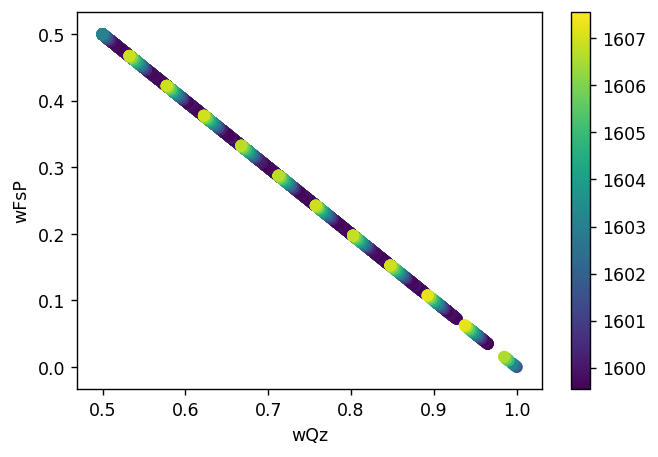

In [80]:
indices_vS = np.array(indices_vS)
x_vS = indices_vS[:, 0]
y_vS = indices_vS[:, 1]+indices_vS[:, 2]
z_vS = np.array(vS_calc)

plt.subplots(dpi=125)
plt.scatter(x=x_vS, y=y_vS, c=z_vS)
plt.colorbar()
plt.xlabel("wQz")
plt.ylabel("wFsP")

In [81]:
GR_calc = []
indices_GR = []
limit_lower_GR = 0.925
limit_upper_GR = 1.075

GR_sample = d[0][3]
GR_Qz = properties_GR[0]
GR_Kfs = properties_GR[1]
GR_Pl = properties_GR[2]
GR_H2O = properties_GR[3]

print("Gamma Ray GR")
print("Sample GR:", GR_sample)
print("Allowed range:", round(limit_lower_GR*GR_sample, 3), round(limit_upper_GR*GR_sample, 3))
print("")

start = time.process_time()
if GR_sample > 10:
    for j in w_Kfs:
        for k in w_Pl:
            if j > k:
                w_fsp = j+k
                if w_fsp <= 0.5:
                    for i in w_Qz:
                        if i+j+k == 1.0:
                            for l in w_H2O:
                                phi = round((l/rho_H2O)/(i/rho_Qz + j/rho_Kfs + k/rho_Pl + l/rho_H2O), 4)
                                value_GR = (1-phi)*(i*GR_Qz + j*GR_Kfs + k*GR_Pl) + phi*GR_H2O
                                if limit_lower_GR*GR_sample < value_GR < limit_upper_GR*GR_sample:
                                    GR_calc.append(value_GR)
                                    indices_GR.append([i, j, k, l])
else:
    for j in w_Kfs:
        for k in w_Pl:
            w_fsp = j+k
            if w_fsp <= 0.5:
                for i in w_Qz:
                    if i+j+k == 1.0:
                        for l in w_H2O:
                            phi = round((l/rho_H2O)/(i/rho_Qz + j/rho_Kfs + k/rho_Pl + l/rho_H2O), 4)
                            value_GR = (1-phi)*(i*GR_Qz + j*GR_Kfs + k*GR_Pl) + phi*GR_H2O
                            if limit_lower_GR*GR_sample < value_GR < limit_upper_GR*GR_sample:
                                GR_calc.append(value_GR)
                                indices_GR.append([i, j, k, l])
                                
print("Needed time:", round(time.process_time() - start, 3), "s")
print("Datapoints:", len(GR_calc))

Gamma Ray GR
Sample GR: 3.386
Allowed range: 3.132 3.64

Needed time: 5.199 s
Datapoints: 10045


Text(0, 0.5, 'wFsP')

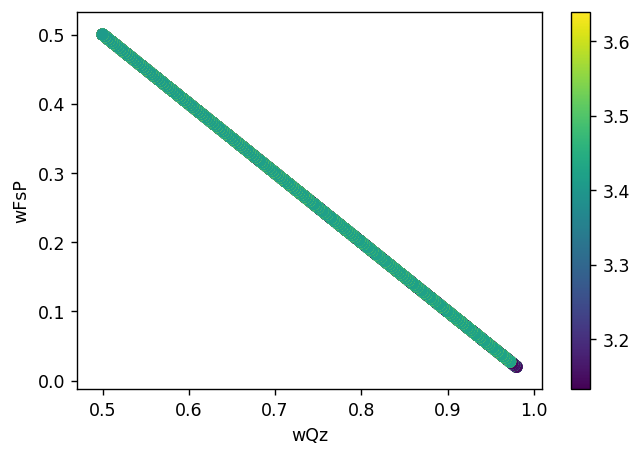

In [82]:
indices_GR = np.array(indices_GR)
x_GR = indices_GR[:, 0]
y_GR = indices_GR[:, 1]+indices_GR[:, 2]
z_GR = np.array(GR_calc)

plt.subplots(dpi=125)
plt.scatter(x=x_GR, y=y_GR, c=z_GR)
plt.colorbar()
plt.xlabel("wQz")
plt.ylabel("wFsP")

In [83]:
PE_calc = []
indices_PE = []
limit_lower_PE = 0.99
limit_upper_PE = 1.01

PE_sample = d[0][4]
PE_Qz = properties_PE[0]
PE_Kfs = properties_PE[1]
PE_Pl = properties_PE[2]
PE_H2O = properties_PE[3]

print("Photoelectric Effect PE")
print("Sample PE:", PE_sample)
print("Allowed range:", round(limit_lower_PE*PE_sample, 3), round(limit_upper_PE*PE_sample, 3))
print("")

start = time.process_time()
for j in w_Kfs:
    for k in w_Pl:
        w_fsp = j+k
        if w_fsp <= 0.5:
            for i in w_Qz:
                if i+j+k == 1.0:
                    for l in w_H2O:
                        phi = round((l/rho_H2O)/(i/rho_Qz + j/rho_Kfs + k/rho_Pl + l/rho_H2O), 4)
                        value_PE = (1-phi)*(i*PE_Qz + j*PE_Kfs + k*PE_Pl) + phi*PE_H2O
                        if limit_lower_PE*PE_sample < value_PE < limit_upper_PE*PE_sample:
                            PE_calc.append(value_PE)
                            indices_PE.append([i, j, k, l])
                                
print("Needed time:", round(time.process_time() - start, 3), "s")
print("Datapoints:", len(PE_calc))

Photoelectric Effect PE
Sample PE: 1.691
Allowed range: 1.674 1.708

Needed time: 4.972 s
Datapoints: 43029


Text(0, 0.5, 'wFsP')

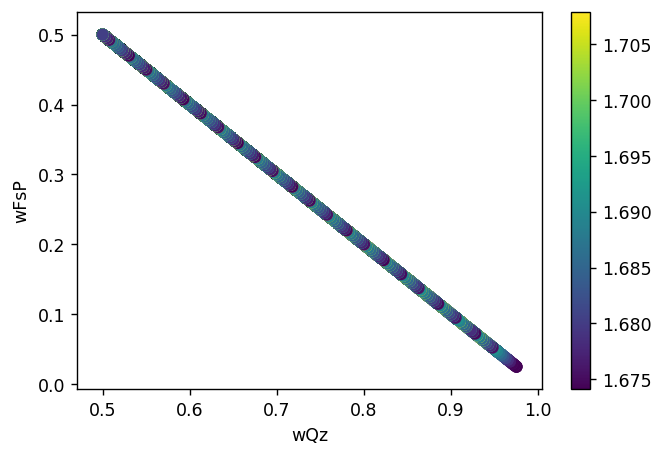

In [84]:
indices_PE = np.array(indices_PE)
x_PE = indices_PE[:, 0]
y_PE = indices_PE[:, 1]+indices_PE[:, 2]
z_PE = np.array(PE_calc)

plt.subplots(dpi=125)
plt.scatter(x=x_PE, y=y_PE, c=z_PE)
plt.colorbar()
plt.xlabel("wQz")
plt.ylabel("wFsP")

In [111]:
rho_calc = []
vP_calc = []
vS_calc = []
GR_calc = []
PE_calc = []
indices = []
phi_calc = []

limit_lower_rho = 0.99
limit_upper_rho = 1.01
limit_lower_vP = 0.95
limit_upper_vP = 1.05
limit_lower_vS = 0.95
limit_upper_vS = 1.05
limit_lower_GR = 0.95
limit_upper_GR = 1.05
limit_lower_PE = 0.925
limit_upper_PE = 1.075

n_rho = 0
n_PE = 0
n_vS = 0
n_vP = 0
n_GR = 0

print("Calculation started!")
start = time.process_time()

for j in w_Kfs:
    for k in w_Pl:
        w_fsp = j+k
        if w_fsp <= 0.5:
            for i in w_Qz:
                if i+j+k == 1.0:
                    for l in w_H2O:
                        phi = round((l/rho_H2O)/(i/rho_Qz + j/rho_Kfs + k/rho_Pl + l/rho_H2O), 4)
                        value_rho = 0.3911*((1-phi)*(i*rho_Qz + j*rho_Kfs + k*rho_Pl) + phi*rho_H2O)
                        if limit_lower_rho*rho_sample < value_rho < limit_upper_rho*rho_sample:
                            #print("Density rho check!")
                            n_rho += 1
                            value_PE = (1-phi)*(i*PE_Qz + j*PE_Kfs + k*PE_Pl) + phi*PE_H2O
                            if limit_lower_PE*PE_sample < value_PE < limit_upper_PE*PE_sample:
                                #print("Photoelectricity PE check!")
                                n_PE += 1
                                value_vS = 0.5282*((1-phi)*(i*vS_Qz + j*vS_Kfs + k*vS_Pl) + phi*vS_H2O)
                                if limit_lower_vS*vS_sample < value_vS < limit_upper_vS*vS_sample:
                                    #print("Velocity vS check!")
                                    n_vS += 1
                                    value_vP = 0.5282*((1-phi)*(i*vP_Qz + j*vP_Kfs + k*vP_Pl) + phi*vP_H2O)
                                    if limit_lower_vP*vP_sample < value_vP < limit_upper_vP*vP_sample:
                                        #print("Velocity vP check!")
                                        n_vP += 1
                                        value_GR = (1-phi)*(i*GR_Qz + j*GR_Kfs + k*GR_Pl) + phi*GR_H2O
                                        if limit_lower_GR*GR_sample < value_GR < limit_upper_GR*GR_sample:
                                            #print("Gamma Ray GR check!")
                                            n_GR += 1
                                            rho_calc.append(value_rho)
                                            vP_calc.append(value_vP)
                                            vS_calc.append(value_vS)
                                            GR_calc.append(value_GR)
                                            PE_calc.append(value_PE)
                                            indices.append([i, j, k, l])
                                            phi_calc.append(phi)
                        
print("Needed time:", round(time.process_time() - start, 3), "s")
print("Calculation done!")
print("Datapoints:", len(rho_calc))
print("Checkpoints summary:")
print("n(rho) =", n_rho)
print("n(vP) =", n_vP)
print("n(vS) =", n_vS)
print("n(GR) =", n_GR)
print("n(PE) =", n_PE)

Calculation started!
Needed time: 4.886 s
Calculation done!
Datapoints: 0
Checkpoints summary:
n(rho) = 0
n(vP) = 0
n(vS) = 0
n(GR) = 0
n(PE) = 0


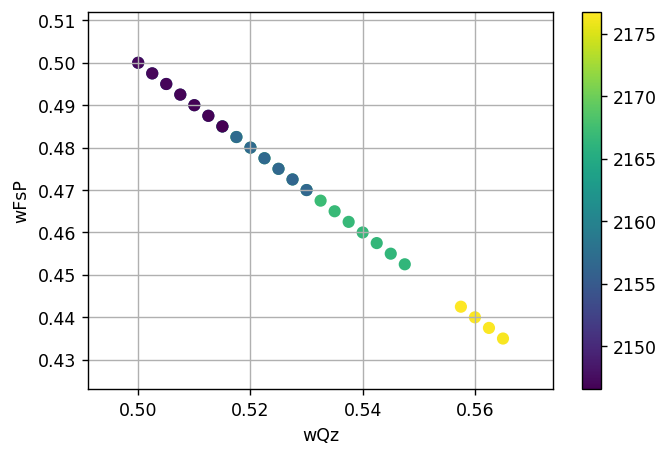

In [110]:
indices = np.array(indices)
x = indices[:, 0]
y = indices[:, 1]+indices[:, 2]
z = np.array(rho_calc)

plt.subplots(dpi=125)
plt.scatter(x=x, y=y, c=z)
plt.colorbar()
plt.xlabel("wQz")
plt.ylabel("wFsP")
plt.grid()